# 7:3 Train/Test Ratio

In [1]:
# import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [2]:
# read data
df = pd.read_csv('ACB.csv')
df = df[['Price','Open','High']]

In [3]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbos

,Price_x,Open_x,High_x
Price_y,1.0,0.011,0.0125
Open_y,0.0,1.000,0.0000
High_y,0.0,0.000,1.0000


In [4]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  612.63    > 24.2761   =>   True
Open   ::  148.03    > 12.3212   =>   True
High   ::  0.65      > 4.1296    =>   False


In [5]:
df =  df[['Price','Open']]

In [6]:
# check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -0.787497
p-value: 0.822767




In [7]:
# differencing
from statsmodels.tsa.stattools import adfuller
df_difference = df.diff().dropna()
adf1 = adfuller(df_difference['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -23.666766
p-value: 0.000000




In [8]:
# Split train/test
train_size = int(0.3 * len(df))
train = df_difference[:-train_size]
test = df_difference[-train_size:]

In [9]:
# find the best fit model
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  20.83427522869372
BIC:  20.853073175727445

Order = 2
AIC:  20.700127654551334
BIC:  20.73147225033745

Order = 3
AIC:  20.617358799609246
BIC:  20.661261812355384

Order = 4
AIC:  20.57384990249288
BIC:  20.630323118412367

Order = 5
AIC:  20.53895632652061
BIC:  20.608011549870373

Order = 6
AIC:  20.49705404478558
BIC:  20.57870309790416

Order = 7
AIC:  20.490297747401062
BIC:  20.584552470746722

Order = 8
AIC:  20.469677136997213
BIC:  20.576549389186155

Order = 9
AIC:  20.459394305601563
BIC:  20.57889596344625

Order = 10
AIC:  20.44586698882785
BIC:  20.5780099473754



C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored 

In [10]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,21.77,21.77,2.838e+09,21.77
1,20.85,20.87,1.131e+09,20.85
2,20.71,20.74,9.882e+08,20.72
3,20.63,20.67,9.087e+08,20.64
4,20.58,20.64,8.691e+08,20.60
5,20.55,20.62,8.383e+08,20.57
6,20.50,20.59,8.030e+08,20.53
7,20.50,20.59,7.967e+08,20.53
8,20.47,20.58,7.795e+08,20.51
9,20.46,20.58,7.707e+08,20.51


In [11]:
result = model.fit(11)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     00:39:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    20.5763
Nobs:                     1734.00    HQIC:                   20.4851
Log likelihood:          -22589.0    FPE:                7.46985e+08
AIC:                      20.4316    Det(Omega_mle):     7.27556e+08
--------------------------------------------------------------------
Results for equation Price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             7.916389         4.358611            1.816           0.069
L1.Price         -0.054712         0.024253           -2.256           0.024
L1.Open          -0.072774         0.028566           -2.548           0.011

In [12]:
# Get the lag order
lag_order = result.k_ar
lagged_Values = train.values[-lag_order:]

# Forecast
pred = result.forecast(y=lagged_Values, steps=len(test)+30) 

idx = pd.RangeIndex(start=len(train), stop=len(df)+29, step=1)
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['price_1d', 'open_1d'])

In [13]:
# Convert differenced values into original values
df_forecast['PriceForecast'] = df['Price'].iloc[-train_size-1] + df_forecast['price_1d'].cumsum()
df_forecast['OpenForecast'] = df['Open'].iloc[-train_size-1] + df_forecast['open_1d'].cumsum()
df_forecast_30 = df_forecast[-30:]
df_forecast = df_forecast[:-30]

In [18]:
# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
test_score_rmse_lstm = np.sqrt(mean_squared_error(df[-train_size:]['Price'], df_forecast['PriceForecast']))
test_score_mape_lstm = mean_absolute_percentage_error(df[-train_size:]['Price'], df_forecast['PriceForecast']) * 100
test_score_msle_lstm = mean_squared_log_error(df[-train_size:]['Price'], df_forecast['PriceForecast'])

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 4531.319300845888
MAPE trên tập test là: 14.287464936327721
MSLE trên tập test là: 0.03927650392101271


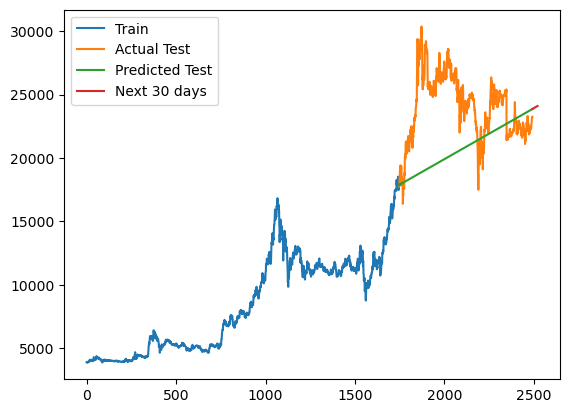

In [15]:
# Plot
plt.plot(df[:-train_size].index, df[:-train_size]['Price'], label='Train')
plt.plot(test.index, df[-train_size:]['Price'], label='Actual Test')
plt.plot(df[-train_size:].index, df_forecast['PriceForecast'], label='Predicted Test')
plt.plot(df_forecast_30.index, df_forecast_30['PriceForecast'], label='Next 30 days')
plt.legend()
plt.show()

# 8:2 Tran/Test Ratio

In [19]:
# import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [20]:
# read data
df = pd.read_csv('ACB.csv')
df = df[['Price','Open','High']]

In [21]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbos

,Price_x,Open_x,High_x
Price_y,1.0,0.011,0.0125
Open_y,0.0,1.000,0.0000
High_y,0.0,0.000,1.0000


In [22]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  612.63    > 24.2761   =>   True
Open   ::  148.03    > 12.3212   =>   True
High   ::  0.65      > 4.1296    =>   False


In [23]:
df =  df[['Price','Open']]

In [24]:
# check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -0.787497
p-value: 0.822767




In [25]:
# differencing
from statsmodels.tsa.stattools import adfuller
df_difference = df.diff().dropna()
adf1 = adfuller(df_difference['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -23.666766
p-value: 0.000000




In [26]:
# Split train/test
train_size = int(0.2 * len(df))
train = df_difference[:-train_size]
test = df_difference[-train_size:]

In [27]:
# find the best fit model
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  21.546147514330485
BIC:  21.562998682379295

Order = 2
AIC:  21.414614417181763
BIC:  21.442711276811004

Order = 3
AIC:  21.34198778006085
BIC:  21.38133960942142

Order = 4
AIC:  21.29267056395986
BIC:  21.343286653667867

Order = 5
AIC:  21.251732960700462
BIC:  21.313622613860236

Order = 6
AIC:  21.231421808780855
BIC:  21.304594341008034

Order = 7
AIC:  21.20425667473619
BIC:  21.28872141418086

Order = 8
AIC:  21.19451981987572
BIC:  21.290286107245596

Order = 9
AIC:  21.175258546067955
BIC:  21.282335734651635

Order = 10
AIC:  21.170252346385173
BIC:  21.288649802075437



C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored 

In [28]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,22.69,22.69,7.136e+09,22.69
1,21.56,21.57,2.302e+09,21.56
2,21.42,21.45,2.016e+09,21.43
3,21.35,21.39,1.873e+09,21.37
4,21.30,21.35,1.781e+09,21.32
5,21.26,21.32,1.708e+09,21.28
6,21.24,21.31,1.672e+09,21.26
7,21.21,21.29,1.626e+09,21.24
8,21.20,21.29,1.608e+09,21.23
9,21.18,21.29*,1.576e+09,21.22


In [30]:
result = model.fit(9)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     00:50:39
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    21.2823
Nobs:                     1985.00    HQIC:                   21.2146
Log likelihood:          -26611.6    FPE:                1.57144e+09
AIC:                      21.1753    Det(Omega_mle):     1.54179e+09
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           11.870861         5.613357            2.115           0.034
L1.Price        -0.036190         0.022911           -1.580           0.114
L1.Open         -0.032814         0.034783           -0.943           0.345
L2.P

In [31]:
# Get the lag order
lag_order = result.k_ar
lagged_Values = train.values[-lag_order:]

# Forecast
pred = result.forecast(y=lagged_Values, steps=len(test)+30) 

idx = pd.RangeIndex(start=len(train), stop=len(df)+29, step=1)
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['price_1d', 'open_1d'])

In [32]:
# Convert differenced values into original values
df_forecast['PriceForecast'] = df['Price'].iloc[-train_size-1] + df_forecast['price_1d'].cumsum()
df_forecast['OpenForecast'] = df['Open'].iloc[-train_size-1] + df_forecast['open_1d'].cumsum()
df_forecast_30 = df_forecast[-30:]
df_forecast = df_forecast[:-30]

In [33]:
# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
test_score_rmse_lstm = np.sqrt(mean_squared_error(df[-train_size:]['Price'], df_forecast['PriceForecast']))
test_score_mape_lstm = mean_absolute_percentage_error(df[-train_size:]['Price'], df_forecast['PriceForecast']) * 100
test_score_msle_lstm = mean_squared_log_error(df[-train_size:]['Price'], df_forecast['PriceForecast'])

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 6337.585140716106
MAPE trên tập test là: 24.557808038590633
MSLE trên tập test là: 0.058819088759445935


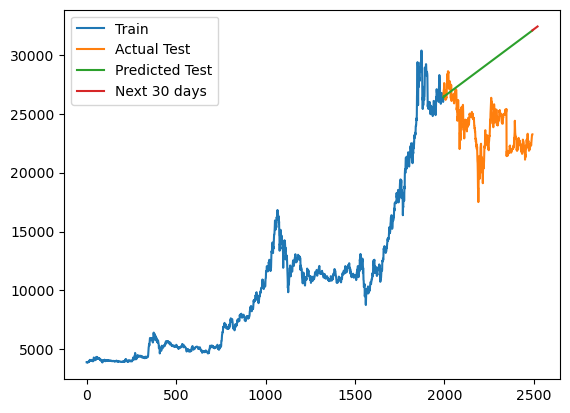

In [34]:
# Plot
plt.plot(df[:-train_size].index, df[:-train_size]['Price'], label='Train')
plt.plot(test.index, df[-train_size:]['Price'], label='Actual Test')
plt.plot(df[-train_size:].index, df_forecast['PriceForecast'], label='Predicted Test')
plt.plot(df_forecast_30.index, df_forecast_30['PriceForecast'], label='Next 30 days')
plt.legend()
plt.show()

# 9:1 Train/Test Ratio

In [35]:
# import libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

#read data
df = pd.read_csv('ACB.csv')
df = df[['Price','Open','High']]

In [36]:
# Testing Causation using Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)    

C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbos

,Price_x,Open_x,High_x
Price_y,1.0,0.011,0.0125
Open_y,0.0,1.000,0.0000
High_y,0.0,0.000,1.0000


In [37]:
# Cointegration Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Price  ::  612.63    > 24.2761   =>   True
Open   ::  148.03    > 12.3212   =>   True
High   ::  0.65      > 4.1296    =>   False


In [38]:
df =  df[['Price','Open']]

In [39]:
# check stationary
from statsmodels.tsa.stattools import adfuller
adf1 = adfuller(df['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -0.787497
p-value: 0.822767




In [40]:
# differencing
from statsmodels.tsa.stattools import adfuller
df_difference = df.diff().dropna()
adf1 = adfuller(df_difference['Price'], regression ='c', maxlag=30)
print("ADF stat: %f" % adf1[0])
print("p-value: %f" % adf1[1])
print('\n')

ADF stat: -23.666766
p-value: 0.000000




In [41]:
# Split train/test
train_size = int(0.1 * len(df))
train = df_difference[:-train_size]
test = df_difference[-train_size:]

In [42]:
# find the best fit model
for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  21.974814408083088
BIC:  21.990109118886743

Order = 2
AIC:  21.80923387340174
BIC:  21.83473444222727

Order = 3
AIC:  21.736721465423173
BIC:  21.77243541007848

Order = 4
AIC:  21.674143433525696
BIC:  21.720078280823053

Order = 5
AIC:  21.637513675022586
BIC:  21.693676960793443

Order = 6
AIC:  21.60898902317786
BIC:  21.675388292287714

Order = 7
AIC:  21.587319222944313
BIC:  21.663962029307573

Order = 8
AIC:  21.57617612838227
BIC:  21.663070034977178

Order = 9
AIC:  21.554554560220645
BIC:  21.65170713910422

Order = 10
AIC:  21.552318822013543
BIC:  21.659737654336556



C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Manh Khuong\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored 

In [43]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,23.11,23.11,1.087e+10,23.11
1,21.98,22.00,3.530e+09,21.99
2,21.82,21.84,2.989e+09,21.83
3,21.74,21.78,2.777e+09,21.76
4,21.68,21.73,2.606e+09,21.70
5,21.64,21.70,2.510e+09,21.66
6,21.61,21.68,2.438e+09,21.64
7,21.59,21.67,2.383e+09,21.62
8,21.58,21.67,2.355e+09,21.61
9,21.56,21.65*,2.302e+09,21.59


In [44]:
result = model.fit(9)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     00:51:37
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    21.6517
Nobs:                     2234.00    HQIC:                   21.5900
Log likelihood:          -30378.3    FPE:                2.29628e+09
AIC:                      21.5546    Det(Omega_mle):     2.25771e+09
--------------------------------------------------------------------
Results for equation Price
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            9.484803         6.108296            1.553           0.120
L1.Price        -0.016992         0.021712           -0.783           0.434
L1.Open          0.062181         0.036450            1.706           0.088
L2.P

In [45]:
# Get the lag order
lag_order = result.k_ar
lagged_Values = train.values[-lag_order:]

# Forecast
pred = result.forecast(y=lagged_Values, steps=len(test)+30) 

idx = pd.RangeIndex(start=len(train), stop=len(df)+29, step=1)
df_forecast=pd.DataFrame(data=pred, index=idx, columns=['price_1d', 'open_1d'])

In [46]:
# Convert differenced values into original values
df_forecast['PriceForecast'] = df['Price'].iloc[-train_size-1] + df_forecast['price_1d'].cumsum()
df_forecast['OpenForecast'] = df['Open'].iloc[-train_size-1] + df_forecast['open_1d'].cumsum()
df_forecast_30 = df_forecast[-30:]
df_forecast = df_forecast[:-30]

In [47]:
# Evaluating
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, mean_squared_log_error
test_score_rmse_lstm = np.sqrt(mean_squared_error(df[-train_size:]['Price'], df_forecast['PriceForecast']))
test_score_mape_lstm = mean_absolute_percentage_error(df[-train_size:]['Price'], df_forecast['PriceForecast']) * 100
test_score_msle_lstm = mean_squared_log_error(df[-train_size:]['Price'], df_forecast['PriceForecast'])

print('RMSE trên tập test là:', test_score_rmse_lstm)
print('MAPE trên tập test là:', test_score_mape_lstm)
print('MSLE trên tập test là:', test_score_msle_lstm)

RMSE trên tập test là: 1910.5774060001481
MAPE trên tập test là: 7.798894609843831
MSLE trên tập test là: 0.0066411081040617095


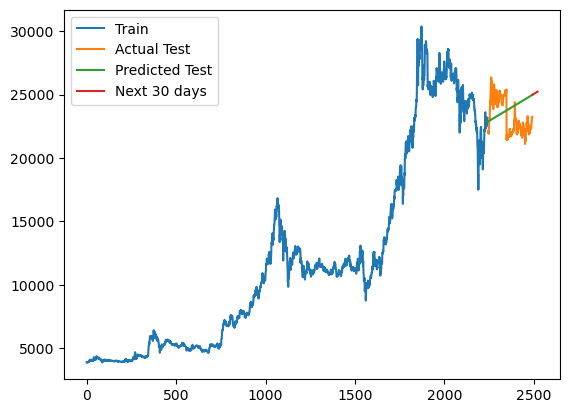

In [48]:
# Plot
plt.plot(df[:-train_size].index, df[:-train_size]['Price'], label='Train')
plt.plot(test.index, df[-train_size:]['Price'], label='Actual Test')
plt.plot(df[-train_size:].index, df_forecast['PriceForecast'], label='Predicted Test')
plt.plot(df_forecast_30.index, df_forecast_30['PriceForecast'], label='Next 30 days')
plt.legend()
plt.show()